Structure:

- Get images
  - Per patient
  - Train
  - Test
-Run all images through feature detection
-Take each patient, run PCA with k =?
-Run MLP classifier / linear discriminator

# Imports and drive

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
#import kornia
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
import cv2

import re
import json 
import glob

from torch.utils.data import Dataset, DataLoader

from sklearn.decomposition import PCA, KernelPCA

# %matplotlib notebook
%matplotlib inline

In [2]:
# Connect to drive to save work
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Proj_B
#!git clone https://github.com/mocedon/VISL_project
#!git pull
%cd VISL_project

Mounted at /content/gdrive
/content/gdrive/MyDrive/Proj_B
/content/gdrive/MyDrive/Proj_B/VISL_project


# Goofing around

In [18]:
max([1,3,2,5,3,6,3,4,2,5,3,4])

6

In [ ]:
l1 = [1,2,3,4,5,6,7]
l2 = l1
l2 = [i for i in l2 if i%2 == 0]
print(l1)
print(l2)

[1, 2, 3, 4, 5, 6, 7]
[2, 4, 6]


In [ ]:
d = [{"t":"ts" , "m":"msi", "im":0},
     {"t":"ts" , "m":"mss", "im":1},
     {"t":"ts" , "m":"mss", "im":2},
     {"t":"ts" , "m":"msi", "im":3},
     {"t":"ts" , "m":"mss", "im":4},
     {"t":"ts" , "m":"mss", "im":5},
     {"t":"tr" , "m":"msi", "im":6},
     {"t":"tr" , "m":"msi", "im":7},
     {"t":"tr" , "m":"mss", "im":8},
     {"t":"tr" , "m":"mss", "im":9}]
p = pd.DataFrame(d)
p[(p["t"]== 'ts')&(p["m"]=='msi')]

,t,m,im
0,ts,msi,0
3,ts,msi,3


In [ ]:
t = torch.rand(3,16,16)
print("torch shape", t.shape)
print("np shape", t.numpy().shape)

torch shape torch.Size([3, 16, 16])
np shape (3, 16, 16)


In [ ]:
t = None
a = torch.Tensor([1,2,3])
b = torch.Tensor([4,5,6])
t = torch.vstack((t,a)) if t else a
t = torch.vstack((t,b,a,b)) 
print(t)

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [1., 2., 3.],
        [4., 5., 6.]])


# Fake data

In [ ]:
def fake_data(dir = './data', ptns=12, pchs=10):
  imgs = torch.rand((ptns, pchs,3, 224,224))
  os.mkdir(dir)
  classes = []
  for p in range(ptns):
    case = 'A' if torch.randn(1) > 0 else 'B'
    classes.append(case)
    p_name = "ptn-{}-{}".format(str(p).zfill(3), case)
    pth = os.path.join(dir, p_name)
    os.mkdir(pth)
    for i in range(pchs):
      im = imgs[int(p),i]
      if case is 'B':
        im = im / 2
      fname = os.path.join(dir ,p_name, str(i).zfill(3) + '.png')
      torchvision.utils.save_image(im, fname)
  return classes

In [ ]:
!rm -fr data*
!rm -fr aug_data*
!ls

sample_data


In [ ]:
dir = './data'
classes = fake_data(dir)
!ls

data  sample_data


In [ ]:
def batch_PCA_(imgs ,k=16):
  print("batch input size: {}".format(imgs.shape))
  ret = imgs.mean(dim=0)
  print("batch new size: {}".format(ret.shape))
  return ret

In [ ]:
%pwd

'/content/gdrive/MyDrive/Proj_B/VISL_project'

# Util Functions

In [3]:
def ds_img(imgs):
  s = imgs.shape[-1] // 8
  t = transforms.RandomCrop(s)
  return t(imgs)

In [4]:
def get_device():
  dev = "cuda:0" if torch.cuda.is_available() else "cpu"
  device = torch.device(dev)
  return device

In [5]:
def parse_patches(fn ,id):
  dir, bn = os.path.split(fn)
  patient = '-'.join(bn.split('-')[3:5])
  dir, label = os.path.split(dir)
  dir, ds = os.path.split(dir)
  return {'id': id,
          'file_name': fn,
          'set': ds,
          'label': label,
          'patient': patient}

In [6]:
def mkdir(dir_, dir):
  """Creeates directory if necessary and returns dir path"""
  d = os.path.join(dir_,dir)
  if not os.path.isdir(d):
    os.mkdir(d)
  return d

In [7]:
def ds_data(dir, nd, n):
  nd = mkdir('./', nd)
  for t in ['test', 'train']:
    d = mkdir(nd, t)
    for m in ['MSI', 'MSS']:
      mkdir(d,m)
      path = os.path.join(dir, t, m)
      print(path)
      for im in glob.glob(path + '/*.png')[:n]:
        #print(im)
        name = os.path.basename(dir)
        repl = os.path.basename(nd)
        np = im.replace(name, repl)
        #print(np)
        if not os.path.isfile(np):
          shutil.copy(im, np)

#ds_data('./../dataset', './../small_dataset', 10000)
#ds_data('./../dataset', './../dataset_ds', 1000)

# Data manipulation

## DS Class

In [8]:
class PatchDataset(Dataset):
  def __init__(self, dir, parse_fn=parse_patches, transform=None):
    self.patch_list = []
    for i, fn in enumerate(glob.glob(dir + "/*/*/*.png")):
      self.patch_list.append(parse_fn(fn, i))
    self.active_list = self.patch_list.copy()
    self.patient_dict = None
    self.transform = transform
    print("found "+str(len(self.patch_list)))

  def set_filter(self, ds=None, lb=None, pt=None):
    if (ds):
      self.active_list = [p for p in self.active_list if p['set'] == ds]
    if (lb):
      self.active_list = [p for p in self.active_list if p['label'] == lb]
    if (pt):
      self.active_list = [p for p in self.active_list if p['patient'] == pt]
  
  def reset_filter(self):
    self.active_list = self.patch_list.copy()
  
  def get_sct(self, sect, num=False):
    l_ = [p[sect] for p in self.active_list]
    l_dct = {}
    for l in l_:
      l_dct[l] = l_dct.get(l, 0) + 1
    return l_dct.items() if num else l_dct.keys()

  def get_patients(self, num=False):
    return self.get_sct('patient', num)

  def get_sets(self, num=False):
    return self.get_sct('set', num)
  
  def get_labels(self, num=False):
    return self.get_sct('label', num)
  
  def __len__(self):
    return len(self.active_list)

  def __getitem__(self, index):
    fn = self.active_list[index]["file_name"]
    lb = self.active_list[index]['label']
    img = torchvision.io.read_image(fn)
    if self.transform:
      img = self.transform(img)
    return (img, lb)

## Dimension reduction 

In [9]:
def add_vec(mat, vec):
  print("shape mat", mat.shape)
  print("shape vec", vec.shape)
  return mat


class batch_PCA():
  def __init__(self, k=2, mean=False, eig_val=False, fnc=None):
    self.k = k
    self.mean = mean
    self.eig_val = eig_val
    self.fnc = fnc

  def __call__(self, ftrs):
    if self.fnc is not None:
      ftrs = self.fnc(ftrs)
    #print("Batch PCA input size: {}".format(ftrs.shape))
    p, f = ftrs.shape
    if p < f:
      avg = torch.mean(ftrs, dim=0)
      for i in range(int(p) - int(f)):
        ftrs = torch.vstack((ftrs, avg))
    ftrs = ftrs.detach().cpu().numpy()
    #ftr_var = (ftrs.T @ ftrs).cpu().numpy()
    PCA_comp = PCA(self.k, svd_solver='full').fit(ftrs)
    eig_vec = torch.Tensor(PCA_comp.components_)
    if self.mean:
      mean = torch.mean(torch.from_numpy(ftrs), dim=0)
      eig_vec = torch.vstack((eig_vec, mean))
    if self.eig_val:
      eig_val = torch.from_numpy(PCA_comp.singular_values_)
      eig_vec = torch.vstack((eig_vec, eig_val))
    #print("Eigen Vector size :{} , with max: {}".format(eig_vec.shape, eig_vec.max()))
    return eig_vec



In [10]:
def incpt3_out2():
  model = models.inception_v3(pretrained=True)
  model.fc = nn.Sequential(nn.Linear(2048,100), nn.Linear(100,2))
  weights = torch.load('./../results/2022_03_13__22_59_56/checkpoints/epoch_17.pth', map_location=torch.device('cpu'))
  model.load_state_dict(weights['net'])
  model.to(get_device())
  model.eval()
  return model


def incpt3_out100():
  model = models.inception_v3(pretrained=True)
  model.fc = nn.Sequential(nn.Linear(2048,100), nn.Linear(100,2))
  weights = torch.load('./../results/2022_03_13__22_59_56/checkpoints/epoch_17.pth', map_location=torch.device('cpu'))
  model.load_state_dict(weights['net'])
  model.fc = model.fc[0]
  model.to(get_device())
  model.eval()
  return model


def patient_data(dir, nd, model_fnc, dr_fnc, trf=None):
  model = model_fnc()
  ds = PatchDataset(dir, transform=trf)
  nd = mkdir('./', nd)
  for t in ds.get_sets():
    s = mkdir(nd, t)
    for m in ds.get_labels():
     d = mkdir(s, m)
     ds.set_filter(ds=t, lb=m)
     for p, sz in ds.get_patients(num=True):
       print("Patient {} - of group {}-{} has {} patches".format(p,t,m,sz))
       ds.set_filter(ds=t, lb=m, pt=p)
       fname = os.path.join(d, p + '.npy')
       if (len(ds) >= 2) and not os.path.isfile(fname):
        dr = dr_fnc(ds, model).cpu().numpy()
        with open(fname, 'wb') as f:
           np.save(f, dr)
       ds.reset_filter()
     ds.reset_filter()


def patientPCA(ds, model):
  bt_sz = 64
  dl = torch.utils.data.DataLoader(ds, batch_size=bt_sz, shuffle=False, num_workers=4)
  ftrs = None
  with torch.no_grad():
    for data in dl:
      imgs = data[0].to(get_device())
      ftr = model(imgs)
      ftrs = torch.vstack((ftrs, ftr)) if ftrs is not None else ftr
  return batch_PCA(ftrs, k=2, mean=False, eig_val=False)


def patientRes(ds, model):
  bt_sz = 64
  dl = torch.utils.data.DataLoader(ds, batch_size=bt_sz, shuffle=False, num_workers=4)
  ftrs = None
  with torch.no_grad():
    for data in dl:
      imgs = data[0].to(get_device())
      ftr = model(imgs)
      ftrs = torch.vstack((ftrs, ftr)) if ftrs is not None else ftr
  return ftrs


def read_mtx(path):
  with open(path, 'rb') as f:
    return np.load(f)

# ML Part

In [11]:
class MLPmodel(nn.Module):
  def __init__(self, input, fnc):
    super(MLPmodel, self).__init__()
    self.fnc = fnc
    self.mlp = nn.Sequential(
        nn.Linear(input, input),
        nn.ReLU(inplace=True),
        nn.Linear(input, 2), 
        nn.Softmax(dim=1))

    
  def forward(self, ev):
    ev = self.fnc(ev[0, 0])
    ev = torch.flatten(ev)
    ev_ = torch.Tensor(1, len(ev))
    ev_[0] = ev_
    return self.mlp(ev_)


class LinearReg(nn.Module):
  def __init__(self, input, fnc):
    super(LinearReg, self).__init__()
    self.fnc = fnc
    self.mlp = nn.Sequential(
        nn.Linear(input, 2, bias=True),
        nn.Softmax(dim=1))

  def forward(self, ev):
    ev = self.fnc(ev[0, 0])
    ev = torch.flatten(ev)
    ev_ = torch.Tensor(1, len(ev))
    ev_[0] = ev_
    ev_ = self.mlp(ev_)
    return ev_

In [37]:
class equalDataset(Dataset):
  def __init__(self, dir, transform=None):
    self.classes = {}
    cl_lb = {}
    glob_list = glob.glob(dir + "/*/*.npy")
    for i, fn in enumerate(glob_list):
      dir, bn = os.path.split(fn)
      dir, label = os.path.split(dir)
      if label not in cl_lb.keys():
        cl_lb[label] = len(self.classes.keys())
        self.classes[cl_lb[label]] = []
      self.classes[cl_lb[label]].append({'pt': fn, 'id': i})
    self.max_cl = max([len(p) for p in self.classes.values()])
    self.transform = transform
  
  def __len__(self):
    max_cl = self.max_cl
    return max_cl * len(self.classes.keys())

  def __getitem__(self, index):
    lb = index // self.max_cl
    i = index % len(self.classes[lb])
    fn = self.classes[lb][i]["pt"]
    img = read_mtx(fn)
    if self.transform:
      img = self.transform(img)
    return (img, lb)

## Train

In [13]:
def calculate_accuracy(model, dataloader, criterion, device):
    """Used on a set model to gain loss and accuracy, does not train"""
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    total_loss = 0
    with torch.no_grad():
        for data in dataloader: # Batch wise check
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # Run the images through the net
            _, predicted = torch.max(outputs.data, 1) # Top  result
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            total_loss += criterion(outputs, labels).data.item() / len(dataloader)

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, total_loss


def train(hp):
  
  model = hp["model"].to("cpu")
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr= hp['lr'])
  ds_train, ds_test = hp['dataset']
  ld_train = torch.utils.data.DataLoader(ds_train, batch_size=hp['bts'], shuffle=True)
  ld_test = torch.utils.data.DataLoader(ds_test, batch_size=hp['bts'], shuffle=True)
  device = torch.device("cpu")

    # training loop
  train_error = []
  test_error = []
  for epoch in range(1, hp['epochs'] + 1):
      model.train()  # put in training mode
      running_loss = 0.0
      epoch_time = time.time()
      for i, data in enumerate(ld_train, 0):
          # get the inputs
          inputs, labels = data
          # send them to device
          inputs = inputs.to(device)
          labels = labels.to(device)
          #ref = torch.Tensor(1, 1)
          #ref[0] = labels
          #labels = ref

          # forward + backward + optimize
          outputs = model(inputs)  # forward pass
          loss = criterion(outputs, labels)  # calculate the loss
          # always the same 3 steps
          optimizer.zero_grad()  # zero the parameter gradients
          loss.backward()  # backpropagation
          optimizer.step()  # update parameters

          # Add statistics
          train_error.append(loss.data.item())
          running_loss += loss.data.item()

      # Advance in learning rate schedule
      # Normalizing the loss by the total number of train batches
      running_loss /= len(ld_train)

      # Calculate training/test set accuracy of the existing model
      train_accuracy, _= calculate_accuracy(model, ld_train, criterion, device)
      test_accuracy, test_loss = calculate_accuracy(model, ld_test, criterion, device)
      test_error.append(test_loss)
      log = "Epoch: {:2d} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
      #train_error.append(running_loss)
      epoch_time = time.time() - epoch_time
      log += "Epoch Time: {:.2f} secs".format(epoch_time)
      print(log)
    
  print('==> Finished Training ...')

  # Graph test and train loss across iterations
  batches = len(ld_train)
  itr = list(range(hp['epochs'] * batches))
  plt.plot(itr, train_error, 'r--', label='Train batch loss', linewidth=0.5)
  itr = list(range(batches,(hp['epochs'] * len(ld_train)+batches), batches))
  plt.plot(itr, test_error, color='g', label='Test Epoch loss', linewidth= 3)
  plt.title('Loss')
  plt.xlabel('Batch')
  plt.ylim(0, max(train_error))
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # save model
  print('==> Saving model ...')
  state = {
      'net': model.state_dict(),
      'epoch': epoch,
  }
  if not os.path.isdir('checkpoints'):
      os.mkdir('checkpoints')
  torch.save(state, './checkpoints/' + hp['name'] +'.pth')
   

In [16]:
def process(dir_train, dir_test , model, name):
  transform = transforms.Compose([transforms.ToTensor()])
  dataset = []
  dataset.append(equalDataset(dir=dir_train, transform=transform))
  dataset.append(equalDataset(dir=dir_test, transform=transform))

  hyper_parameters = {
      'model': model,
      'lr': 1e-3,
      'bts': 1,
      'dataset': dataset,
      'epochs': 20,
      'name': name
  }
  train(hyper_parameters)


def exp_pca(ftrs):
  return batch_PCA(torch.exp(ftrs))

# Run Networks

## Data stats

In [11]:
class rgb2hsv():
    """Convert images from RGB to HSV."""
    def __call__(self, image):
        # swap color axis because
        # torch image: C x H x W
        # numpy image: H x W x C
        image = image.cpu().numpy()
        image = image.transpose((1, 2, 0))
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        hsv = hsv.transpose((2, 0, 1))
        hsv = torch.from_numpy(hsv)
        return hsv


def patch_stat(ds):
  dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False)
  hist = torch.zeros(3,256)
  for im, _ in dl:
    for i in range(256):
      for c in range(3):
        hist[c][i] += torch.sum(im[0][c] == i)
  norm = torch.sum(hist[0][:])
  hist = hist / norm
  plt.plot(range(256), hist[0][:], color='r')
  plt.plot(range(256), hist[1][:], color='g')
  plt.plot(range(256), hist[2][:], color='b')
  #plt.show()
  hist /= 3
  ent = (-hist) * torch.log(hist + 0.0001)
  ent = torch.sum(ent)
  print("Data entropy is : {}".format(ent))



In [ ]:
plt.figure(figsize=(16, 12))

ds_hsv = PatchDataset('./../dataset_ds', transform=rgb2hsv())
plt.subplot(321)
patch_stat(ds_hsv)
plt.title("HSV - all")

ds_hsv.set_filter(lb="MSI")
plt.subplot(323)
patch_stat(ds_hsv)
plt.title("HSV - MSI")
ds_hsv.reset_filter()

ds_hsv.set_filter(lb="MSS")
plt.subplot(325)
patch_stat(ds_hsv)
plt.title("HSV - MSS")


ds_rgb = PatchDataset('./../dataset_ds')
plt.subplot(322)
patch_stat(ds_rgb)
plt.title("RGB - all")

ds_rgb.set_filter(lb="MSI")
plt.subplot(324)
patch_stat(ds_rgb)
plt.title("RGB - MSI")
ds_rgb.reset_filter()

ds_rgb.set_filter(lb="MSS")
plt.subplot(326)
patch_stat(ds_rgb)
plt.title("RGB - MSS")

In [ ]:
def show_res(dir):
  ds = torchvision.datasets.DatasetFolder(root=dir, loader=read_mtx, extensions='.npy')
  dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)

  for i, data in enumerate(dl):
    if i < 1:
      mat, lb = data
      lb= int(lb.cpu())
      mat = mat.numpy()[0]
      ln = len(mat[:,0])
      cl = 0 if lb == 0 else 90
      cl = [cl + int(10*l/ln) for l in range(ln)]
      print(cl)
      plt.scatter(mat[:,0], mat[:,1], c=cl)
  plt.show()
  
show_res('../dataset_2d_matrix_mm')

## runs

In [ ]:
trf = transforms.Compose([transforms.ToPILImage(),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
patient_data('./../dataset', './../dataset_2d_res', incpt3_out2, patientRes, trf=trf)

In [ ]:
trf = transforms.Compose([transforms.ToPILImage(),
                          transforms.ToTensor(),
                          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
patient_data('./../dataset', './../dataset_100d_res', incpt3_out100, patientRes, trf=trf)

260
{'MSIMUT': 0, 'MSS': 1}
100
{'MSIMUT': 0, 'MSS': 1}
Epoch:  1 | Loss: nan | Training accuracy: 50.000% | Test accuracy: 50.000% | Epoch Time: 43.05 secs
Epoch:  2 | Loss: nan | Training accuracy: 50.000% | Test accuracy: 50.000% | Epoch Time: 1.98 secs
Epoch:  3 | Loss: nan | Training accuracy: 50.000% | Test accuracy: 50.000% | Epoch Time: 2.00 secs
Epoch:  4 | Loss: nan | Training accuracy: 50.000% | Test accuracy: 50.000% | Epoch Time: 2.03 secs
Epoch:  5 | Loss: nan | Training accuracy: 50.000% | Test accuracy: 50.000% | Epoch Time: 1.98 secs
Epoch:  6 | Loss: nan | Training accuracy: 50.000% | Test accuracy: 50.000% | Epoch Time: 1.98 secs
Epoch:  7 | Loss: nan | Training accuracy: 50.000% | Test accuracy: 50.000% | Epoch Time: 1.97 secs
Epoch:  8 | Loss: nan | Training accuracy: 50.000% | Test accuracy: 50.000% | Epoch Time: 1.99 secs
Epoch:  9 | Loss: nan | Training accuracy: 50.000% | Test accuracy: 50.000% | Epoch Time: 2.03 secs
Epoch: 10 | Loss: nan | Training accuracy: 

ValueError: ignored

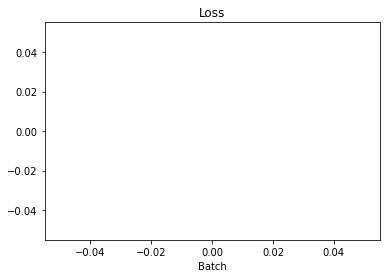

In [38]:
process('../dataset_2d_res/train', '../dataset_2d_res/test', MLPmodel(8, batch_PCA(k=2, mean=True, eig_val=True, fnc=torch.exp)), "LR_test")

In [ ]:
process('../dataset_100d_res/train', '../dataset_100d_res/test', LinearReg(200, exp_pca), "100d_pca")

In [ ]:
process('../dataset_100d_res/train', '../dataset_100d_res/test', MLPmodel(200, exp_pca), "100d_pca")

# Grave yard

In [12]:
class vgg16_features(nn.Module):
  def __init__(self):
    super(vgg16_features, self).__init__()
    self.m = torchvision.models.vgg16(pretrained=True)

  def forward(self, imgs):
    ftrs = self.m.features(imgs)
    return torch.max(ftrs, dim=1).values
    

In [11]:
class AutoEncoder(nn.Module):

  def __init__(self, head, rest):
    super(AutoEncoder, self).__init__()
    self.encode = head
    self.decode = rest
  
  def forward(self, imgs):
    x = self.encode(imgs)
    return self.decode(x)

  def feature_ext(self, imgs):
    return self.encode(imgs)

In [ ]:
class patches_DataSet(torchvision.datasets.DatasetFolder):
  def __init__(self, root='./data'):
    super(torchvision.datasets.DatasetFolder, self).init__(root=root, loader=torchvision.io.read_image, extensions='.png')

  def find_classes(dir):
    return None

In [ ]:
def get_class(ds, dir):
  cls = ds.find_classes(dir)[0]
  ret = []
  for c in cls:
    case = c[-1]
    ret.append(case)
  return ret